# Gaussian Processes
In this notebook I visualize the effects of radial basis function (RBF) kernel parameters (length scale and variance) and Gaussian noise variance in Gaussian processes. GPy package is used in this notebook.

Check this article on Distill which contains a great visual introduction to Gaussian processes: https://distill.pub/2019/visual-exploration-gaussian-processes/

[Check my Github repository for similar introductory notebooks](https://github.com/YZouzou/ML-Topics-Intro)

In [2]:
import numpy as np
import GPy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

A Gaussian process requires a prior as an input (mean and covariance matrix), which represents our prior knowledge about the predicted variable:
* **Mean:** The prior mean is usually assumed 0 as it has almost no effect on the resulting regression function. It is worth mentioning that predictions outside the training data range tend to approach the prior mean, therefore extrapolations return non-realistic results. A value other than zero can be assigned to the prior mean, which will be added to the resulting zero-mean Gaussian distribution.
* **Covariance Matrix:** The covariance matrix determines the variance of variables and their dependency on each other in a Gaussian distribution. A covariance matrix should be positive semi-definite. Kernel functions are used to create the covariance matrix in Gaussian processes. The choice of a kernel functions should be based on our knowledge of the nature of our data and how it varies (linearly, periodically, etc.). Each kernel function has a number of parameters that determine the shape of the resulting covariance matrix. The choice of the kernel and its parameters is what determines the quality and accuracy of the GP model.

After determining the prior, making predictions from the prior will return the prior mean with uncertainty ranges corresponding to the variance defined in the kernel function. Using the available training data, and using Bayesian inference, we can obtain the posterior distribution. Then, predictions made from the posterior will have low uncertainty in regions close to available training data, and higher uncertainties as we move away from training data points. Using this method, uncertainty will be zero at training data points, and the regression hyperplane will pass through every single data point, which is considered an overfit. In order to solve this problem, we can add Gaussian noise to the diagonal of the posterior covariance matrix to allow for some uncertainties for training data points and therefore obtain a more generalized regression model.



### Kernels:
There are various kernels that can be used to construct a covariance matrix. In this notebook, I will only consider the radial basis function (RBF) kernel.

* Kernel function:
$$ k(x_{i}, x_{j}) = \sigma^{2}e^{- \frac{(x_{i} - x_{j})^{2}}{2l^2}} $$

$l$ : Length scale

$\sigma^2$ : Variance

$x_i, x_j$ : Data points

When $x_i = x_j$ the result is $\sigma^2$, which is what the diagonal of a covariance matrix should represent (variance). For other values, the closer $x$ values are to each other the larger the result will be, meaning that using an RBF kernel results in higher correlations for data points closer to each other. By manipulating the length scale $l$, we can determine the distance that maintains correlation between data points. For example, a small length scale value will result in small outputs from the RBF kernel function which translates to low correlation. On the other hand, a larger $l$ value will result in larger results, therefore more correlation.

To summarize, length scale determines the interdependence between different points. A large length scale implies high dependence between points further away, therefore the fit would be a smooth function. On the contrary, a small length scale means that points are almost independent, therefore the resulting fit is noisy. A covariance matrix with a small length scale would have zero values almost everywhere apart from the diagonal.

The following visuals will help in visualizing the effects of kernel parameters.

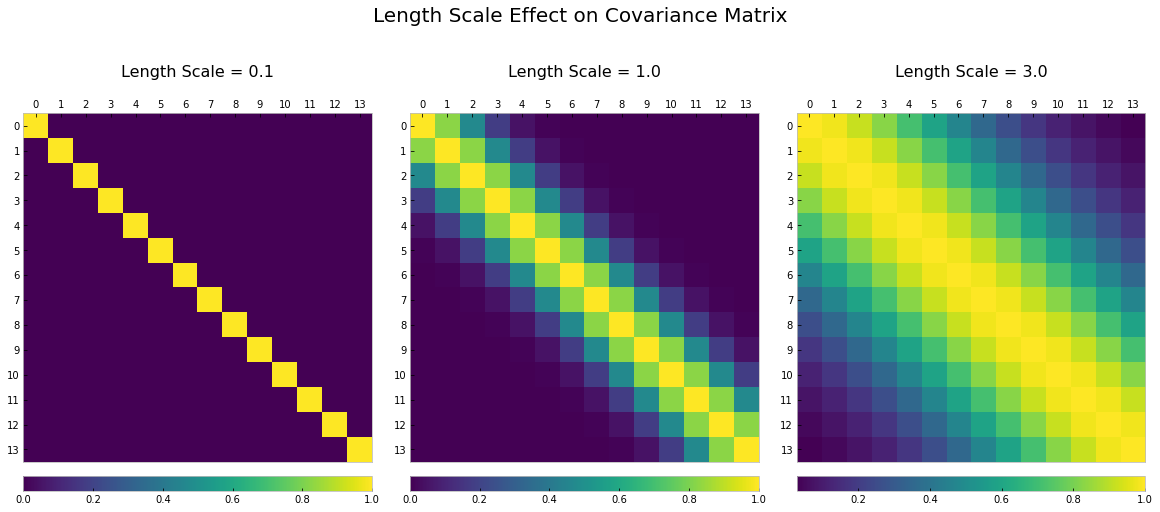

In [3]:
num = 14
x = np.linspace(2, 10, num).reshape(-1, 1)
k1 = GPy.kern.RBF(input_dim = 1)

fig, axs = plt.subplots(1, 3, constrained_layout = True, figsize = (16, 7))
fig.suptitle('Length Scale Effect on Covariance Matrix\n', fontsize = 20)

lengthscale_list = [0.1, 1, 3]

for i, ax in enumerate(axs):
    
    k1.variance = 1
    k1.lengthscale = lengthscale_list[i]
    cov = k1.K(x, x)

    im = ax.imshow(cov)
    fig.colorbar(im, ax = ax, shrink = 1, aspect = 10, location = 'bottom')
    ax.xaxis.set_ticks_position('top')
    ax.set_xticks(range(num))
    ax.set_yticks(range(num))
    ax.set_title('Length Scale = {len}\n'.format(len = k1[1]), fontsize = 16)
    ax.grid(False)

plt.show()

The previous plot is a heat map of the covariance matrix for different length scale values and a constant variance ($\sigma^2 = 1$).

* In the first case, the length scale is very small and therefore all values other than the diagonal are zeros. **There is zero correlation between data points**.
* As the length scale increases, values around the diagonal increase, meaning that there is higher correlations between different points.

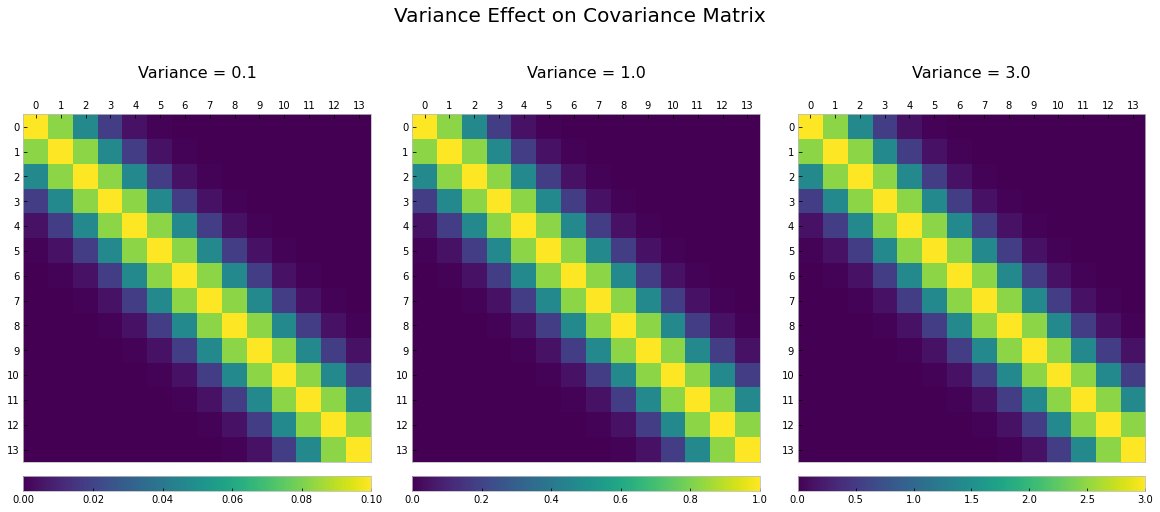

In [128]:
num = 14
x = np.linspace(2, 10, num).reshape(-1, 1)
k1 = GPy.kern.RBF(input_dim = 1)

fig, axs = plt.subplots(1, 3, constrained_layout = True, figsize = (16, 7))
fig.suptitle('Variance Effect on Covariance Matrix\n', fontsize = 20)

variance_list = [0.1, 1, 3]

for i, ax in enumerate(axs):
    
    k1.variance = variance_list[i]
    k1.lengthscale = 1
    cov = k1.K(x, x)

    im = ax.imshow(cov)
    fig.colorbar(im, ax = ax, shrink = 1, aspect = 10, location = 'bottom')
    ax.xaxis.set_ticks_position('top')
    ax.set_xticks(range(num))
    ax.set_yticks(range(num))
    ax.set_title('Variance = {len}\n'.format(len = k1[0]), fontsize = 16)
    ax.grid(False)

plt.show()

The previous plot is a heat map of the covariance matrix for different variance values and a constant length scale ($l = 1$).
* All covariance matrices have the same shape, however variance values vary from one to another (notice the values on the color bars).

Creating a noisy set of data points (training data):

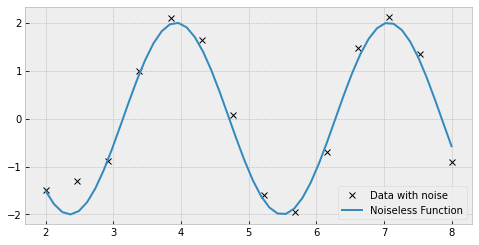

In [4]:
num = 14

# Noisy data points
x = np.linspace(2, 8, num).reshape(-1, 1)

np.random.seed(18)
y = 2*np.sin(2*x) + np.random.randn(num, 1) * 0.3

# Function points
x_fun = np.linspace(2, 8, 50)
y_fun = 2*np.sin(2*x_fun)

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(x, y, 'kx', label = 'Data with noise')
ax.plot(x_fun, y_fun, label = 'Noiseless Function')
ax.legend()
plt.show()

Initializing an RBF kernel with length scale and variance equal to 1

In [42]:
kernel = GPy.kern.RBF(input_dim = 1, lengthscale = 1., variance = 1.)

Creating a GP model using the x, y data created above and the RBF kernel

In [43]:
m = GPy.models.GPRegression(x, y, kernel)

Optimizing the kernel parameters and Gaussian noise using the given training data

In [9]:
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,4.571526440330783,+ve,
rbf.lengthscale,0.911583497505522,+ve,
Gaussian_noise.variance,0.02764699885514095,+ve,


### Function for plotting samples:
**plot_samples** `(ax, m, x, num, x_data = None, y_data =  None, plot_mean = False, alpha_data = 1)`:
* Plots sample functions from the posterior for 1D input and output data.
* ####  Parameters:
    * **ax**: Axes object
    * **m**: Model
    * **x**: X values used to create samples
    * **num**: Number of samples
    * **x_data, y_data**: Training (observation) data
    * **alpha_data**: Data marker opacity

In [34]:
def plot_samples(ax, m, x, num, title, x_data = None, y_data = None, plot_mean = False, alpha_data = 1):
    
    samples = m.posterior_samples_f(x, size = num)[:, 0, :]
    mean, var = m.predict_noiseless(x)
    
    lower_bound, upper_bound = m.predict_quantiles(x)
    lower_bound = lower_bound.flatten()
    upper_bound = upper_bound.flatten()

    mean = mean.flatten()

    ax.plot(x, samples, linewidth = 0.4, color = 'b')
    
    if isinstance(x_data, np.ndarray) and isinstance(y_data, np.ndarray):
        ax.plot(x_data, y_data, 'kx', markersize = 12, label = 'Data', color = 'black', alpha = alpha_data)
        
    ax.fill_between(x.flatten(),lower_bound, upper_bound, color = 'b', alpha = 0.3, label = '95% Confidence Interval')
    
    if plot_mean:
        ax.plot(x, mean, '--', color = 'black', linewidth = 2, label = 'Mean')
        
    ax.legend()
    ax.set_xlim(x[0], x[-1])
    ax.set_title(title)

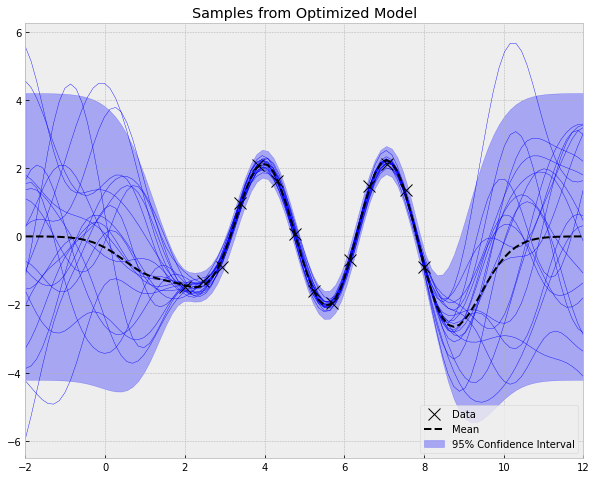

In [35]:
test = np.linspace(-2, 12, 100).reshape(-1, 1)

fig, ax = plt.subplots(figsize = (10, 8))
ax = plot_samples(ax, m, x = test, num = 20, x_data = x, y_data = y, plot_mean = True, title = 'Samples from Optimized Model')

plt.show()

Notice that the mean returns to the prior mean (zero in this case) when data is not available

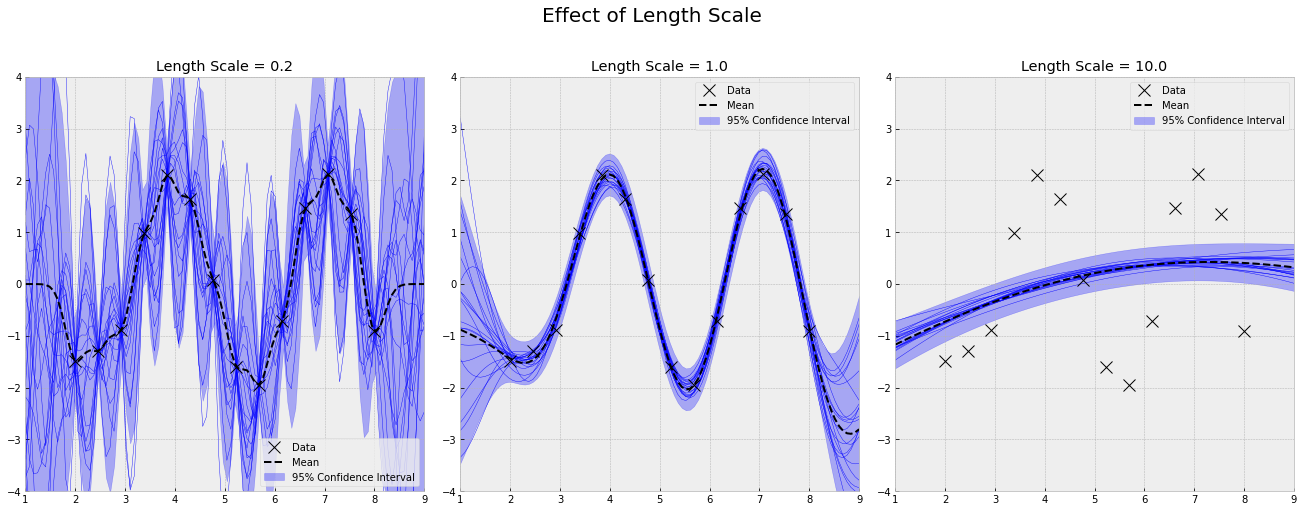

In [36]:
kernel1 = GPy.kern.RBF(input_dim = 1, lengthscale = 1., variance = 1.)
m1 = GPy.models.GPRegression(x, y, kernel1)

m1.rbf.lengthscale = m.rbf.lengthscale
m1.rbf.variance = m.rbf.variance
m1.Gaussian_noise.variance = m.Gaussian_noise.variance

fig, axs = plt.subplots(1, 3, constrained_layout = True, figsize = (18, 7))
fig.suptitle('Effect of Length Scale\n', fontsize = 20)
test = np.linspace(1, 9, 100).reshape(-1, 1)

lengthscale_list = [0.2, 1, 10]

for i, ax in enumerate(axs):
    m1.rbf.lengthscale = lengthscale_list[i]
    
    title = 'Length Scale = {len}'.format(len = m1.rbf[1])
    plot_samples(ax, m1, title = title, x = test, num = 20, x_data = x, y_data = y, plot_mean = True)
    ax.set_ylim(-4, 4)

plt.show()

* For a very small length scale value, points have almost no correlation between each other and the resulting functions are rough (not smooth). (overfit case)
* For a higher length scale value the smoothness of the regression curve increases.
* For very high length scales values, there is high correlation even between points away from each other. Therefore, the resulting regression is an underfit.

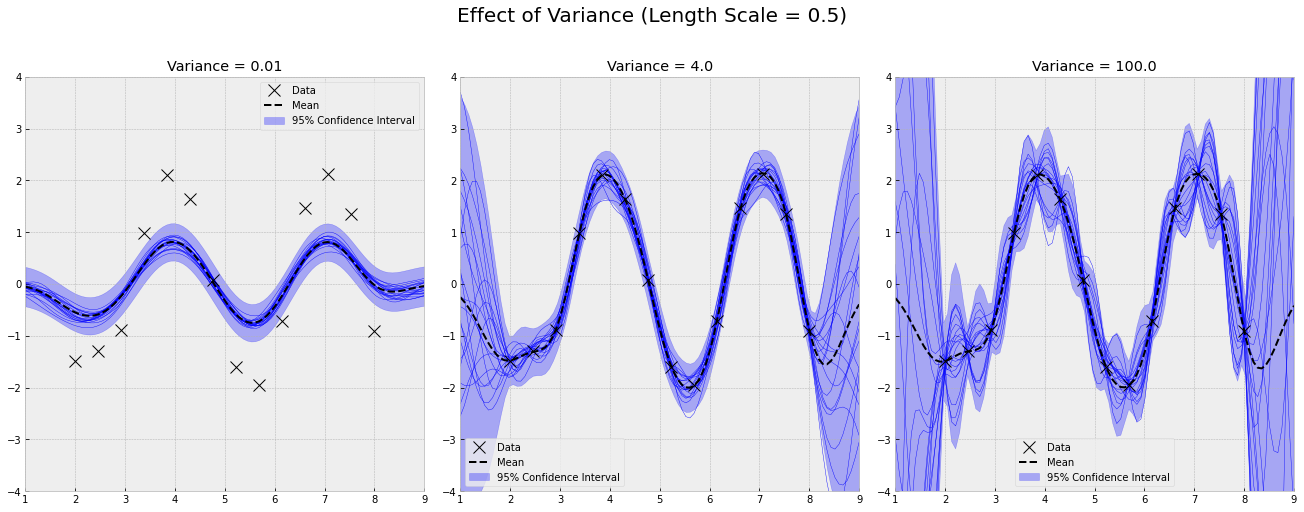

In [37]:
kernel1 = GPy.kern.RBF(input_dim = 1, lengthscale = 1., variance = 1.)
m1 = GPy.models.GPRegression(x, y, kernel1)

m1.rbf.lengthscale = m.rbf.lengthscale
m1.rbf.variance = m.rbf.variance
m1.Gaussian_noise.variance = m.Gaussian_noise.variance

# m1.Gaussian_noise.variance = 0.0001

lengthscale = 0.5
m1.rbf.lengthscale = lengthscale

fig, axs = plt.subplots(1, 3, constrained_layout = True, figsize = (18, 7))
fig.suptitle('Effect of Variance (Length Scale = {})\n'.format(lengthscale), fontsize = 20)
test = np.linspace(1, 9, 100).reshape(-1, 1)

variance_list = [0.01, 4, 100]

for i, ax in enumerate(axs):

    m1.rbf.variance = variance_list[i]
    title = 'Variance = {len}'.format(len = m1.rbf[0])
    plot_samples(ax, m1, title = title, x = test, num = 20, x_data = x, y_data = y, plot_mean = True)
    ax.set_ylim(-4, 4)

plt.show()

* For very small variance values, the regression curve stays near the prior mean if there is Gaussian noise to allow for the curves not to pass through training data points. (Try setting Gaussian noise to zero and notice how the function passes through all points).

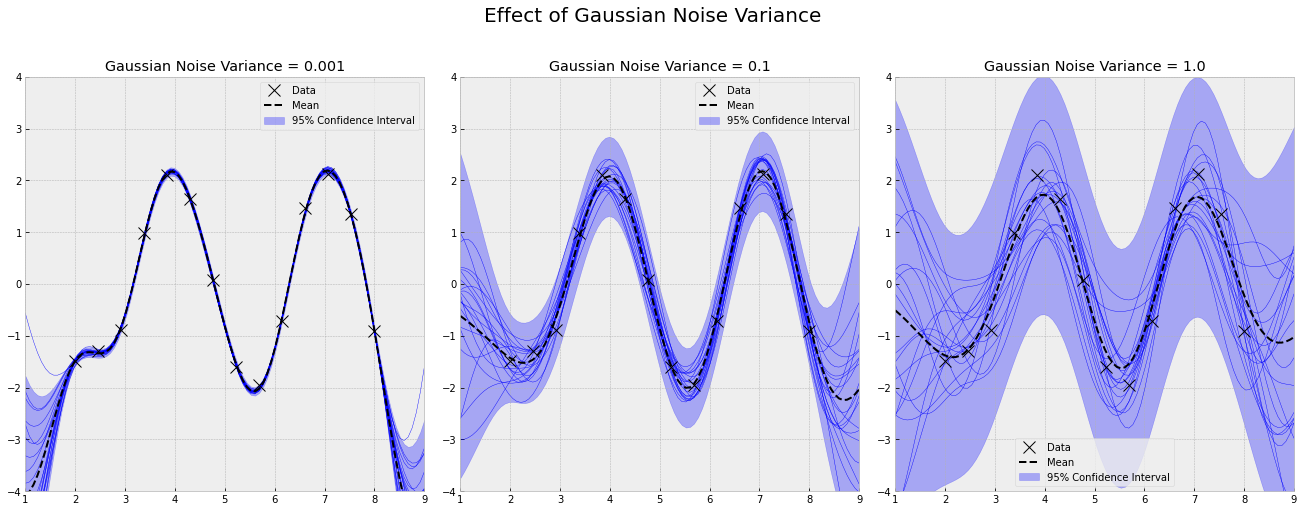

In [38]:
kernel1 = GPy.kern.RBF(input_dim = 1, lengthscale = 1., variance = 1.)
m1 = GPy.models.GPRegression(x, y, kernel1)

m1.rbf.lengthscale = m.rbf.lengthscale
m1.rbf.variance = m.rbf.variance
m1.Gaussian_noise.variance = m.Gaussian_noise.variance

fig, axs = plt.subplots(1, 3, constrained_layout = True, figsize = (18, 7))
fig.suptitle('Effect of Gaussian Noise Variance\n', fontsize = 20)
test = np.linspace(1, 9, 100).reshape(-1, 1)

Gnoise_list = [0.001, 0.1, 1]

for i, ax in enumerate(axs):

    m1.Gaussian_noise.variance = Gnoise_list[i]
    title = 'Gaussian Noise Variance = {len}'.format(len = m1.Gaussian_noise[0])
    plot_samples(ax, m1, title = title, x = test, num = 20, x_data = x, y_data = y, plot_mean = True)
    ax.set_ylim(-4, 4)

plt.show()

* For very low Gaussian noise values, all functions pass through training data points.
* As Gaussian noise values increase, there is more allowability for noise around training data points.

## GPy Notes:
* `m.predict(x)` returns predictions with added likelihood variance (noise).
* `m.predict_noiseless(x)` returns predictions without likelihood variance (noise).
* `m.predict_qauntiles(x)` returns 95% (default) confidence interval **including likelihood variance (noise)**.
* `m.posterior_samples_f(x, size = 10)` returns samples without noise.